## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

from sklearn.metrics import (precision_score, recall_score,
                             accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay)

## Download the Data

In [2]:
import pandas as pd

YEARS = range(2021, 2024)  # 2021 - 2023 data
df_original = pd.DataFrame()

for year in YEARS:
    i_data = pd.read_csv(f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{year}.csv.gz',
                         compression='gzip', low_memory=False)

    # Concatenate the current year's data with the original DataFrame
    df_original = pd.concat([df_original, i_data])

print("done")

done


## Find Data for a timeout before column

In [3]:
# Create an index list for df_original rows
indexing = []
for i in range(0, len(df_original)):
    indexing.append(i)

# Reset index of the original DataFrame and add the custom indexing as a new column
df2 = df_original.reset_index()
df2["indexing"] = indexing

# Filter rows based on conditions related to 'fourth_down_converted', 'fourth_down_failed', 'timeout', and 'play_type'
df2 = df2[(df2["fourth_down_converted"].notna() & df2["fourth_down_failed"].notna()) |
          ((df2["timeout"] == 1) & (df2["play_type"] == "no_play"))]
df2 = df2[(df2["fourth_down_converted"] != df2["fourth_down_failed"]) |
          ((df2["timeout"] == 1) & (df2["play_type"] == "no_play"))]
df2 = df2[df2["play_type"] != "qb_kneel"]

# Identify rows where a timeout occurred just before a non-play
worklist = []
for i in range(0, len(df2)):
    if (df2[["timeout"]].iloc[i, 0] == 1) & (df2[["play_type"]].iloc[i, 0] == "no_play"):
        worklist.append(df2[["indexing"]].iloc[i, 0])

# Create a list that indicates whether a timeout occurred just before each play (excluding 'no_play')
timeoutbefore = []
for i in range(0, len(df2)):
    if df2[["play_type"]].iloc[i, 0] != "no_play":
        if df2[["indexing"]].iloc[i, 0] - 1 in worklist:
            timeoutbefore.append(1)
        else:
            timeoutbefore.append(0)

# Print the size of the 'timeoutbefore' list and the first 10 entries
print("Size:", len(timeoutbefore))
print(timeoutbefore[:10])

Size: 2427
[0, 1, 0, 0, 1, 0, 0, 0, 1, 0]


## Filter dataset

In [4]:
# convert data to only fourth down plays
df = df_original[df_original["fourth_down_converted"].notna() & df_original["fourth_down_failed"].notna()]
df = df[df["fourth_down_converted"] != df["fourth_down_failed"]]
df = df[df["play_type"] != "qb_kneel"]

# convert play type to one hot (currently pass or run)
backlist = []
for i in range(0,len(df)):
    df3 = pd.get_dummies(df['play_type'], drop_first=False)
    backlist.append(df3.iloc[i,0])
for i in range(0,len(df)):
    df.iloc[i,df.columns.get_loc("play_type")] = backlist[i]
df.iloc[0:,df.columns.get_loc("play_type")]
df["is_pass"] = backlist


# convert NaNs in temp to 70
df["temp"].replace(np.nan, 70, inplace=True)

# convert NaNs in wind to 0
df["wind"].replace(np.nan, 0, inplace=True)

#game seconds remaining since drive start
testing_list = []
for i in range(0,len(df)):
    if df[["drive_quarter_start"]].iloc[i, 0] > 4:
        abc = int(df[["drive_game_clock_start"]].iloc[i,0][0:2])*60 + int(df[["drive_game_clock_start"]].iloc[i,0][3:])
    else: abc = int(df[["drive_game_clock_start"]].iloc[i,0][0:2])*60 + int(df[["drive_game_clock_start"]].iloc[i,0][3:])+ int(((4-(df[["drive_quarter_start"]].iloc[i, 0]))*900))
    testing_list.append(abc)
df["seconds_remaining_from_drive_start"] = testing_list


# add the timeout before column
print(df.shape[0], len(timeoutbefore))
df["timeout_before"] = timeoutbefore  #know if timeout happened before hand, 0 for no, 1 for yes


# select the desired columns
# maybe add "season_type"
X = df[["ydstogo", "is_pass", "game_seconds_remaining", "seconds_remaining_from_drive_start", "score_differential",
       "yardline_100", "play_clock", "temp", "wind", "shotgun", "drive_play_count", "timeout_before"]]

# feature selection
# X = df[["ydstogo", "is_pass", "game_seconds_remaining", "seconds_remaining_from_drive_start",
#        "yardline_100", "drive_play_count"]]

y = df["fourth_down_converted"]


print("X size:", X.shape[0])
print("y size:", y.shape[0])
print(X.head(10))

/var/folders/g1/_dy1zns927sgc7nx8t6673w00000gn/T/ipykernel_26434/421475007.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["is_pass"] = backlist
/var/folders/g1/_dy1zns927sgc7nx8t6673w00000gn/T/ipykernel_26434/421475007.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["temp"].replace

2427 2427
X size: 2427
y size: 2427
     ydstogo  is_pass  game_seconds_remaining  \
39         4     True                  2890.0   
148       10     True                   948.0   
164        5     True                   498.0   
212        1    False                  2814.0   
258        1    False                  1873.0   
303        1    False                  1105.0   
411        4     True                  3141.0   
424        4     True                  2781.0   
431        1     True                  2636.0   
514       15     True                   607.0   

     seconds_remaining_from_drive_start  score_differential  yardline_100  \
39                                 3019               -10.0          74.0   
148                                1086               -25.0          49.0   
164                                 664               -25.0          34.0   
212                                2986                 0.0          35.0   
258                                2054

/var/folders/g1/_dy1zns927sgc7nx8t6673w00000gn/T/ipykernel_26434/421475007.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["seconds_remaining_from_drive_start"] = testing_list
/var/folders/g1/_dy1zns927sgc7nx8t6673w00000gn/T/ipykernel_26434/421475007.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["timeout_before"] = timeoutbefore  #know if timeout happened before hand, 0 for no, 1 for yes


## Histogram for each feature to determine if scaling is needed

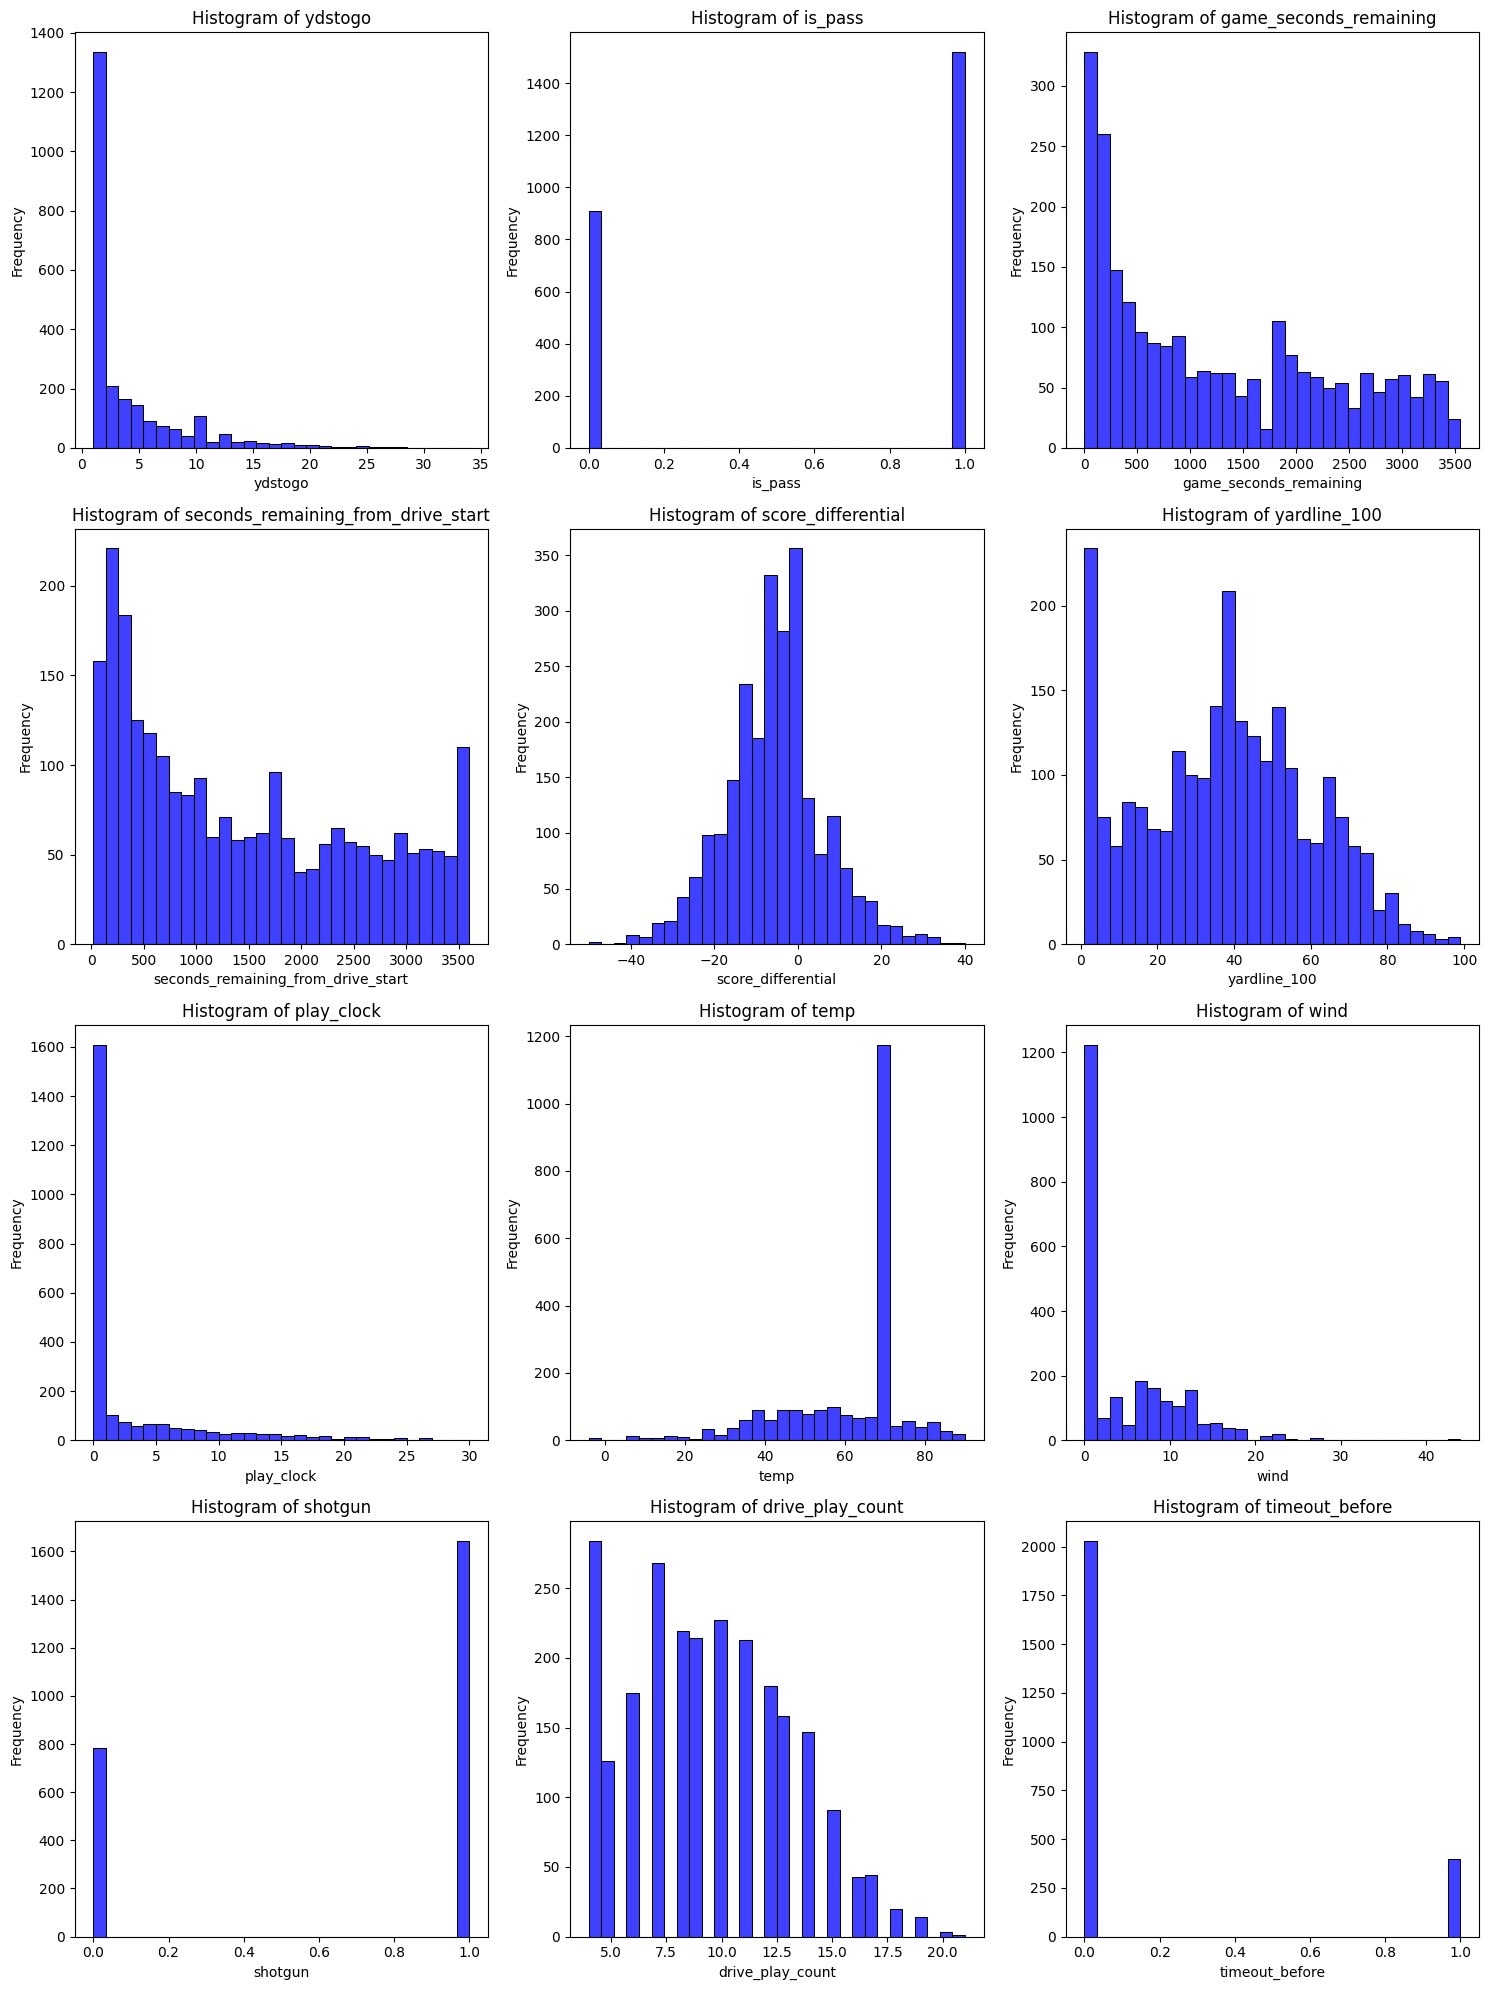

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of rows and columns for subplots based on the number of features
n_cols = 3
n_rows = len(X.columns) // n_cols + (len(X.columns) % n_cols > 0)

# Create a figure to hold the subplots
plt.figure(figsize=(15, 5 * n_rows))

for idx, col in enumerate(X.columns):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(X[col], kde=False, color='blue', bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Prepare train, test, validation data

In [6]:
# split 80% training data, 20% "_tmp" for validation & test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0, stratify=y)
# of remaining 20%, split in half to get 10% validation, 10% test
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
  random_state=0, stratify=y_tmp)

print("train size:", X_train.shape[0])
print("valid size:", X_valid.shape[0])
print("test size:", X_test.shape[0])
print("fourth down converted:\n", y.value_counts(), sep="")


train size: 1941
valid size: 243
test size: 243
fourth down converted:
fourth_down_converted
1.0    1270
0.0    1157
Name: count, dtype: int64


## Do grid search 

/Users/sowmyasubramaniam/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/sowmyasubramaniam/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/sowmyasubramaniam/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/sowmyasubramaniam/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/sowmyasub

Estimator: SVC(C=1000, max_iter=10000, probability=True) {'C': 1000, 'kernel': 'rbf', 'max_iter': 10000}   Score: 0.8395061728395061


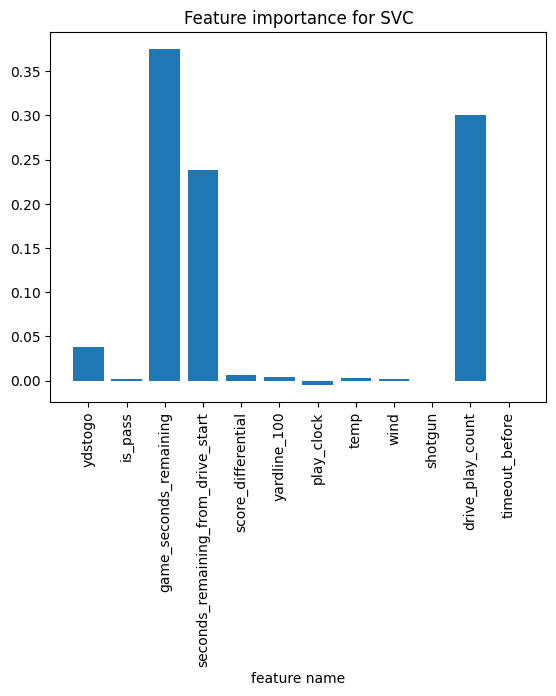

Estimator: LogisticRegression(C=0.01, max_iter=5000) {'C': 0.01, 'max_iter': 5000}   Score: 0.8641975308641975


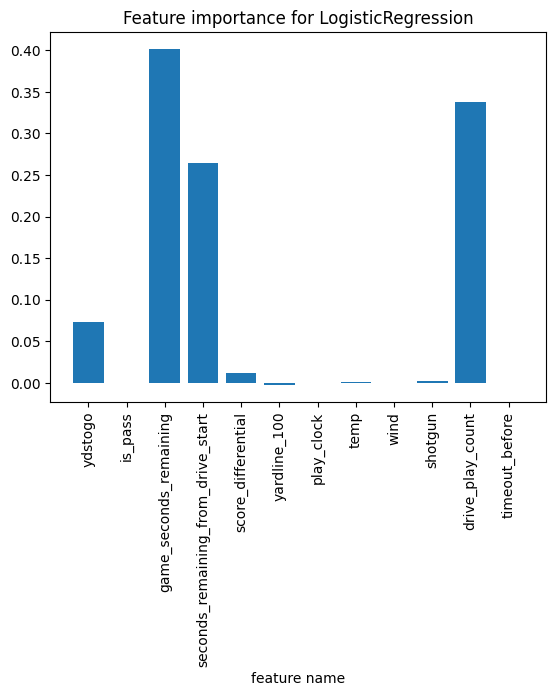

Estimator: DecisionTreeClassifier(criterion='entropy', max_depth=5) {'criterion': 'entropy', 'max_depth': 5}   Score: 0.7818930041152263


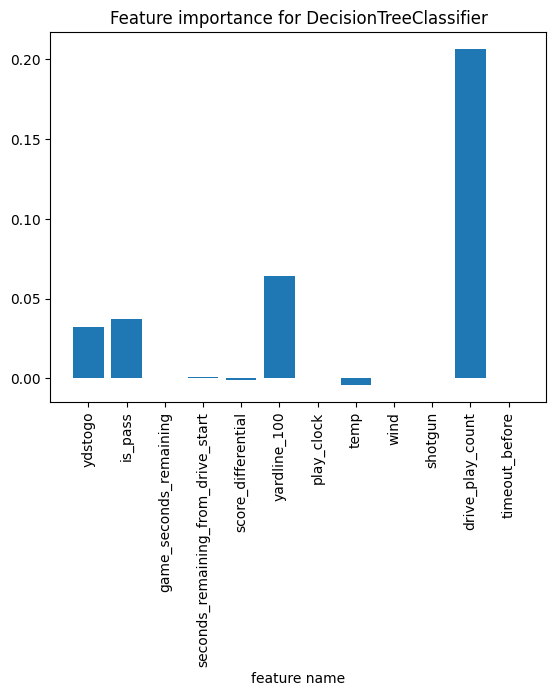

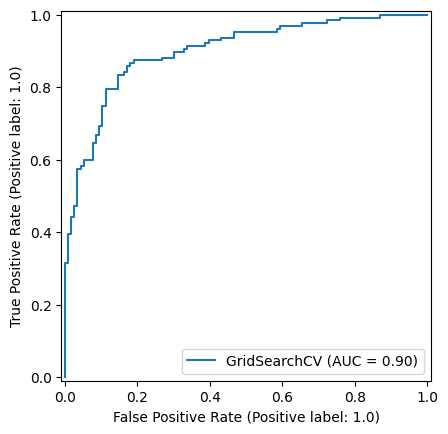

In [7]:
clfs = [
    svm.SVC(probability=True),  # this model is really slow, maybe get rid of it
    linear_model.LogisticRegression(), 
    #linear_model.LinearRegression(), 
    #linear_model.Lasso(), 
    #linear_model.Ridge(), 
    DecisionTreeClassifier()
]
params = [
    {"kernel":["linear", "rbf"], "C":[0.01, 1, 10, 100, 1000], "max_iter":[10000]}, 
    {"max_iter":[5000], "C":[0.0001, 0.001, 0.01, 0.05, 0.1, 1, 10, 100, 1000]}, 
    #{},
    #{"alpha":[0.01, 0.1, 1, 10, 100, 1000]},
    #{"alpha":[0.01, 0.1, 1, 10, 100, 1000]},
    {"criterion":["entropy"], "max_depth":range(1, 16, 2)}, # 1, 3, 5, ..., 15
]


best_clf_i = -1
best_score = -np.Inf
best_clf = None

permutations = {}


for i in range(len(clfs)):
    clf = GridSearchCV(clfs[i], params[i])
    clf.fit(X_train, y_train)
    score = clf.score(X_valid, y_valid)
    print("Estimator:", clf.best_estimator_, clf.best_params_, "  Score:", score)
    
     
    # for permutation feature importance. It would be interesting to have a chart of the
    # most important features for the model we select in our report
    pi = permutation_importance(estimator=clf, X=X_valid, y=y_valid, random_state=0)    
    feature_importances = []
    
    feature_names = X_train.columns.tolist()
    
    pi = permutation_importance(estimator=clf, X=X_valid, y=y_valid, random_state=0)    
    feature_importances = []
    
    feature_names = X_train.columns.tolist()
    
    # Loop through each feature and its importance
    for j in pi.importances_mean.argsort()[::-1]:
        if pi.importances_mean[j] - 2 * pi.importances_std[j] > 0:
            feature_importances.append((feature_names[j], pi.importances_mean[j]))
    # Add model and its feature importances to the dictionary
    permutations[clf] = feature_importances
    
    # add plot for visual confirmation
    plt.bar(x=range(X_train.columns.size), height=pi.importances_mean, tick_label=X_train.columns)
    plt.title(f'Feature importance for {clf.best_estimator_.__class__.__name__}')
    plt.xlabel('feature name')
    plt.xticks(rotation=90)
    plt.savefig(clf.best_estimator_.__class__.__name__ + 'initial.png', bbox_inches = "tight")
    plt.show()    
    

    
    if score > best_score:
        best_clf_i = i
        best_score = score
        best_clf = clf

RocCurveDisplay.from_estimator(best_clf, X_test, y_test)

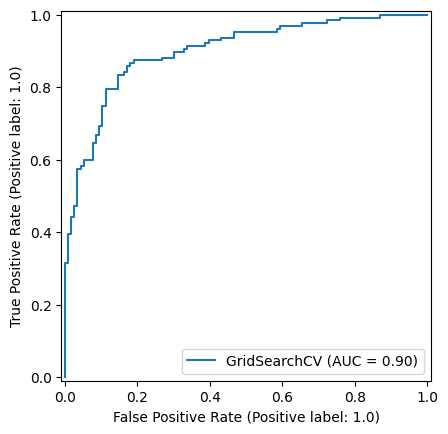

In [8]:
fig = RocCurveDisplay.from_estimator(best_clf, X_test, y_test)

In [9]:
score = best_clf.score(X_test, y_test)
print("Best Estimator:", best_clf.best_estimator_, best_clf.best_params_, "  Score:", score)


y_hat = best_clf.predict(X_test)

precision = precision_score(y_true=y_test, y_pred=y_hat)
recall = recall_score(   y_true=y_test, y_pred=y_hat)
accuracy = accuracy_score(y_true=y_test, y_pred=y_hat)
print(f'precision={precision}, recall={recall}, accuracy={accuracy}')

Best Estimator: LogisticRegression(C=0.01, max_iter=5000) {'C': 0.01, 'max_iter': 5000}   Score: 0.823045267489712
precision=0.8559322033898306, recall=0.7952755905511811, accuracy=0.823045267489712
